**This notebook was made at the request of [Chris-san](https://www.kaggle.com/cdeotte). Thank you for the good opportunity.**

**There are two things that aren't working well.**
- **tqdm.notebook (tqdm.auto) does not work. I'm using tqdm instead.**
- **The color bar becomes transparent and cannot be seen well. Please let me know if you know how to make only the color bar solid.**

**Please try various things and have fun! I hope it helps you.**

**Oct 19th: Added uout1 distribution for test. Same distribution as train.**

This notebook is a continuation of:
- [EDA about time_step and u_out](https://www.kaggle.com/marutama/eda-about-time-step-and-u-out).
- [EDA about u_in](https://www.kaggle.com/marutama/eda-about-u-in)
- [EDA about Pressure Part 1](https://www.kaggle.com/marutama/eda-about-pressure-part-1)
- [EDA about Pressure Part 2](https://www.kaggle.com/marutama/eda-about-pressure-part-2)
- [EDA about: LSTM Feature Importance](https://www.kaggle.com/marutama/eda-about-lstm-feature-importance)
- [finetune of Tensorflow Bi-LSTM EDA about](https://www.kaggle.com/marutama/finetune-of-tensorflow-bi-lstm-eda-about) ... This notebook is for model of above LSTM Feature Importance.

If you find it useful, please upvote it as well.。

Chart Plot referred to [Ventilator Pressure Prediction: EDA, FE and models](https://www.kaggle.com/artgor/ventilator-pressure-prediction-eda-fe-and-models). 

For the R_C distribution part, I referred to [Ventilator Pressure simple EDA](https://www.kaggle.com/currypurin/ventilator-pressure-simple-eda).

Thank you very much.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
#from tqdm.auto import tqdm  # I don't know why widget error ...
from tqdm import tqdm 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load CSV

In [5]:
oj = os.path.join
path = '/Users/Manuel/Desktop/NPS_GoogleBrain/Data'
train = pd.read_csv(oj(path, 'train.csv'))
test  = pd.read_csv(oj(path, 'test.csv'))
sub   = pd.read_csv(oj(path, 'sample_submission.csv'))

# Add features

Groupby is slow, so I don't use it as much as possible.

In [6]:
def add_features(df):
    df['R_C'] = [f'{r:02}_{c:02}' for r, c in zip(df['R'], df['C'])]

    # fast area calculation
    df['time_delta'] = df['time_step'].diff()
    df['time_delta'].fillna(0, inplace=True)
    df['time_delta'].mask(df['time_delta'] < 0, 0, inplace=True)
    df['tmp'] = df['time_delta'] * df['u_in']
    df['area'] = df.groupby('breath_id')['tmp'].cumsum()

    # u_in: max, min, mean, std 
    u_in_max_dict = df.groupby('breath_id')['u_in'].max().to_dict()
    df['u_in_max'] = df['breath_id'].map(u_in_max_dict)
    u_in_min_dict = df.groupby('breath_id')['u_in'].min().to_dict()
    df['u_in_min'] = df['breath_id'].map(u_in_min_dict)
    u_in_mean_dict = df.groupby('breath_id')['u_in'].mean().to_dict()
    df['u_in_mean'] = df['breath_id'].map(u_in_mean_dict)
    u_in_std_dict = df.groupby('breath_id')['u_in'].std().to_dict()
    df['u_in_std'] = df['breath_id'].map(u_in_std_dict)

    # u_in_half is time:0 - time point of u_out:1 rise (almost 1.0s)
    df['tmp'] = df['u_out']*(-1)+1 # inversion of u_out
    df['u_in_half'] = df['tmp'] * df['u_in']

    # u_in_half: max, min, mean, std
    u_in_half_max_dict = df.groupby('breath_id')['u_in_half'].max().to_dict()
    df['u_in_half_max'] = df['breath_id'].map(u_in_half_max_dict)
    u_in_half_min_dict = df.groupby('breath_id')['u_in_half'].min().to_dict()
    df['u_in_half_min'] = df['breath_id'].map(u_in_half_min_dict)
    u_in_half_mean_dict = df.groupby('breath_id')['u_in_half'].mean().to_dict()
    df['u_in_half_mean'] = df['breath_id'].map(u_in_half_mean_dict)
    u_in_half_std_dict = df.groupby('breath_id')['u_in_half'].std().to_dict()
    df['u_in_half_std'] = df['breath_id'].map(u_in_half_std_dict)

    # Groupby is slow, do not use it.
    # All entries are first point of each breath_id
    first_df = df.loc[0::80,:]
    # All entries are first point of each breath_id
    last_df = df.loc[79::80,:]

    # The Main mode DataFrame and flag
    main_df= last_df[(last_df['u_in']>4.8)&(last_df['u_in']<5.1)]
    main_mode_dict = dict(zip(main_df['breath_id'], [1]*len(main_df)))
    df['main_mode'] = df['breath_id'].map(main_mode_dict)
    df['main_mode'].fillna(0, inplace=True)

    # u_out1_timing flag and DataFrame: speed up
    # 高速版 uout1_df 作成
    df['u_out_diff'] = df['u_out'].diff()
    df['u_out_diff'].fillna(0, inplace=True)
    df['u_out_diff'].replace(-1, 0, inplace=True)
    uout1_df = df[df['u_out_diff']==1]

    main_uout1 = uout1_df[uout1_df['main_mode']==1]
    nomain_uout1 = uout1_df[uout1_df['main_mode']==1]

    # Register Area when u_out becomes 1
    uout1_area_dict = dict(zip(first_df['breath_id'], first_df['u_in']))
    df['area_uout1'] = df['breath_id'].map(uout1_area_dict) 

    # u_in: first point, last point
    u_in_first_dict = dict(zip(first_df['breath_id'], first_df['u_in']))
    df['u_in_first'] = df['breath_id'].map(u_in_first_dict)
    u_in_last_dict = dict(zip(first_df['breath_id'], last_df['u_in']))
    df['u_in_last'] = df['breath_id'].map(u_in_last_dict)

    # time(sec) of end point
    time_end_dict = dict(zip(last_df['breath_id'], last_df['time_step']))     
    df['time_end'] = df['breath_id'].map(time_end_dict)

    # time(sec) when u_out becomes 1
    uout1_dict = dict(zip(uout1_df['breath_id'], uout1_df['time_step']))
    df['time_uout1'] = df['breath_id'].map(uout1_dict)

    # u_in when u_out becomes1
    u_in_uout1_dict = dict(zip(uout1_df['breath_id'], uout1_df['u_in']))
    df['u_in_uout1'] = df['breath_id'].map(u_in_uout1_dict)

    # Dict that puts 0 at the beginning of the 80row cycle
    first_0_dict = dict(zip(first_df['id'], [0]*len(uout1_df)))

    # Faster version u_in_diff creation, faster than groupby
    df['u_in_diff'] = df['u_in'].diff()
    df['tmp'] = df['id'].map(first_0_dict) # put 0, the 80row cycle
    df.iloc[0::80, df.columns.get_loc('u_in_diff')] = df.iloc[0::80, df.columns.get_loc('tmp')]

    # Create u_in vibration
    df['diff_sign'] = np.sign(df['u_in_diff'])
    df['sign_diff'] = df['diff_sign'].diff()
    df['tmp'] = df['id'].map(first_0_dict) # put 0, the 80row cycle
    df.iloc[0::80, df.columns.get_loc('sign_diff')] = df.iloc[0::80, df.columns.get_loc('tmp')]

    # Count the number of inversions, so take the absolute value and sum
    df['sign_diff'] = abs(df['sign_diff']) 
    sign_diff_dict = df.groupby('breath_id')['sign_diff'].sum().to_dict()
    df['diff_vib'] = df['breath_id'].map(sign_diff_dict)

    if 'diff_sign' in df.columns:
        df.drop(['diff_sign', 'sign_diff'], axis=1, inplace=True)

    #df['area/uin_h_mean'] = df['area'] / df['u_in_half_mean']

    df['R_Cm'] = df['R_C']
    df.loc[(df['R_C']=='50_10')&(df['main_mode']==1), 'R_Cm'] = '50_10_main'
    df.loc[(df['R_C']=='50_10')&(df['main_mode']!=1), 'R_Cm'] = '50_10_nomain'
    return df  

In [7]:
%%time
train = add_features(train)

CPU times: user 17.3 s, sys: 5.79 s, total: 23.1 s
Wall time: 24.4 s


In [8]:
%%time
test = add_features(test)

CPU times: user 11.4 s, sys: 2.71 s, total: 14.1 s
Wall time: 14.4 s


In [6]:
train.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'R_C', 'time_delta', 'tmp', 'area', 'u_in_max', 'u_in_min', 'u_in_mean',
       'u_in_std', 'u_in_half', 'u_in_half_max', 'u_in_half_min',
       'u_in_half_mean', 'u_in_half_std', 'main_mode', 'u_out_diff',
       'area_uout1', 'u_in_first', 'u_in_last', 'time_end', 'time_uout1',
       'u_in_uout1', 'u_in_diff', 'diff_vib', 'R_Cm'],
      dtype='object')

# Recreate each DataFrame when all the features are available

In [7]:
%%time
################################################################
first_df = train.loc[0::80,:]
last_df = train.loc[79::80,:]
main_df= last_df[(last_df['u_in']>4.8)&(last_df['u_in']<5.1)]
nomain_df = last_df[(last_df['u_in']<=4.8)|(last_df['u_in']>=5.1)]
uout1_df = train[train['u_out_diff']==1]
main_uout1 = uout1_df[uout1_df['main_mode']==1]
nomain_uout1 = uout1_df[uout1_df['main_mode']!=1]

RCorder = list(np.sort(train['R_C'].unique()))
RCmorder = list(np.sort(train['R_Cm'].unique()))
################################################################

CPU times: user 1.7 s, sys: 0 ns, total: 1.7 s
Wall time: 1.69 s


# Functions for plot

In [8]:
def plot_bid(bid, col1='', col2=''):
    fig, ax1 = plt.subplots(figsize = (6, 4)) 
    
    tmp = train.loc[train['breath_id'] == bid].reset_index(drop=True)
    ax2 = ax1.twinx()

    ax1.plot(tmp['time_step'], tmp['pressure'], 'm-', label='pressure')
    ax1.plot(tmp['time_step'], tmp['u_in'], 'g-', label='u_in')
    ax2.plot(tmp['time_step'], tmp['u_out'], 'b-', label='u_out')

    ax1.set_xlabel('Timestep')
    
    R = tmp['R'][0]
    C = tmp['C'][0]
    mean = tmp['u_in_mean'][0]
    std = tmp['u_in_std'][0]
    vib = tmp['diff_vib'][0]
    title_str = f'breath_id:{bid}, R:{R}, C:{C}, mean:{mean:.2f}, std:{std:.2f}, vib:{vib:.1f}'
    if col1 != '':
        c1 = tmp[col1][0]
        title_str += f'{col1}: {c1}'
    if col2 != '':
        c2 = tmp[col2][0]
        title_str += f'{col2}: {c2}'
    ax1.set_title(title_str)

    ax1.set_ylim(0, 100)
    
    ax1.legend(loc=(1.1, 0.8))
    ax2.legend(loc=(1.1, 0.7))
    plt.show()

def plot_uin_list(bid_list, ylim=100, u_low=0, u_high=100, pos=79, alpha=False):
    
    fig, ax1 = plt.subplots(figsize = (6, 4)) # original (12, 8)

    if alpha:
        a = alpha
    else:
        if (len(bid_list)):
            a = max(1.0/len(bid_list), 0.01)
        else:
            a = 1
    
    for bid in tqdm(bid_list):
        tmp = train.loc[train['breath_id'] == bid].reset_index(drop=True)
        u = tmp['u_in'][pos]
        if (u >= u_low) and (u <= u_high):  
            ax1.plot(tmp['time_step'], tmp['u_in'], 'g-', alpha=a)

    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('u_in')
    ax1.set_ylim(0,ylim)
    #ax1.legend(loc=(1.1, 0.8))
    plt.show()
    
def plot_bid_stats(list, indiv=3, df=last_df, max_plots=False, no_uin=False,
                   alpha=False, time_delta=False, col1='', col2=''):
    tmpdf= df[df['breath_id'].isin(list)]
    bid_list = tmpdf['breath_id']
    print('Number of plots:', len(bid_list))
    
    if indiv:
        for bid in bid_list[:indiv]: # 最大3個、個別表示
            plot_bid(bid, col1=col1, col2=col2)

    #plt.hist(tmpdf['R_C'], bins=17) # 棒グラフの順番指定できないので見にくい
    sns.countplot(x="R_C", data=tmpdf, order=RCorder)
    plt.show()
    
    if not no_uin:
        if not max_plots:
            max_plots = len(bid_list)
            print(f'Number of plots: {max_plots}')
        else:
            print(f'Number of plots: {max_plots}/{len(bid_list)}')
        plot_uin_list(bid_list[:max_plots], alpha=alpha)


def plot_double_pre_list(bid_list, max_plots=False, ylim=100, alpha=False):
    fig = plt.figure(figsize = (12, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
       
    ##############################
    title_str = f'time - u_in'
    ax1.set_title(title_str)
    
    ax1.set_ylabel('u_in')
    ax1.set_xlabel('Timestep')

    ax1.set_ylim(0, ylim)
    ##############################
    title_str = f'time - pressure'
    ax2.set_title(title_str)

    ax2.set_ylabel('Pressure')
    ax2.set_xlabel('Timestep')
    
    ax2.set_ylim(0, ylim)
    ##############################
    if alpha:
        a = alpha
    else:
        if (len(bid_list)):
            a = max(1.0/len(bid_list), 0.01)
        else:
            a = 1
    if not max_plots:
        max_plots = len(bid_list)
        
    for bid in tqdm(bid_list[:max_plots]):
        tmp = train.loc[train['breath_id'] == bid].reset_index(drop=True)
        ax1.plot(tmp['time_step'], tmp['u_in'], 'g-', alpha=a)
        ax2.plot(tmp['time_step'], tmp['pressure'], 'm-', alpha=a)
    
    fig.tight_layout()
    plt.show()

# [Note] uout1 is time when u_out becomes 1

# Overview

uout1_df
Number of plots: 75450


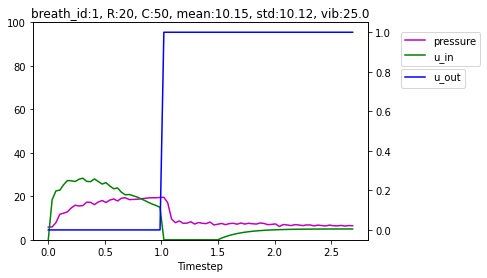

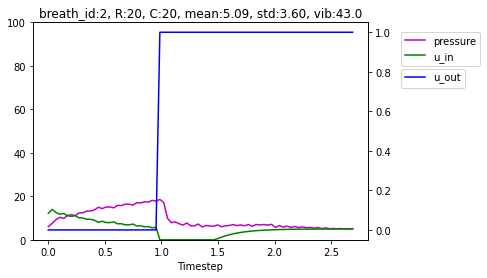

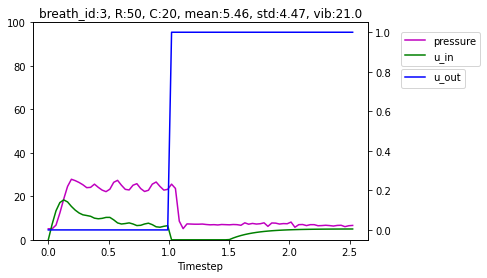

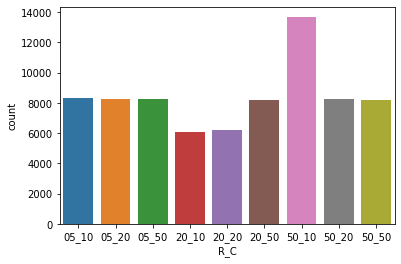

100%|██████████| 1000/1000 [00:07<00:00, 129.31it/s]


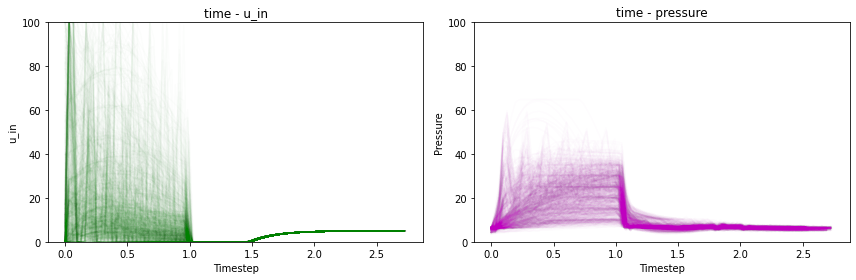

In [9]:
print('uout1_df')
plot_bid_stats(uout1_df['breath_id'], indiv=3, no_uin=True)
plot_double_pre_list(main_df['breath_id'][:1000])

In "other than main mode", there are only R = 50 and C = 10.

# There is a correlation between area and u_in_half_mean(u_in_mean and also u_in.cumsum()) 

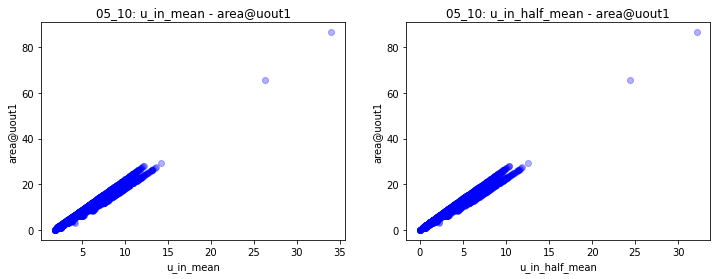

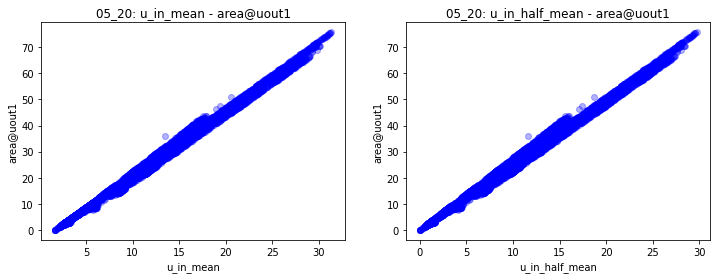

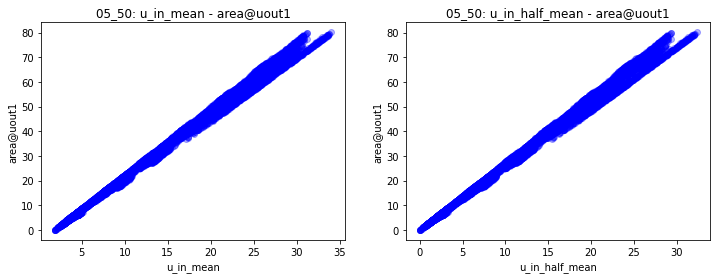

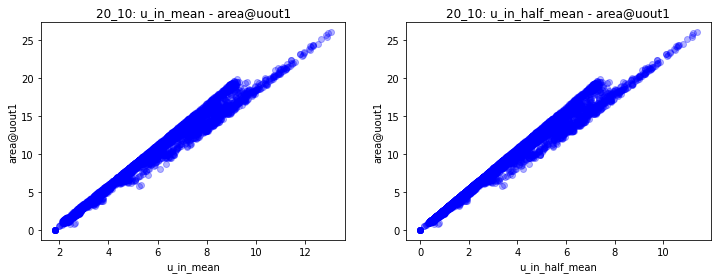

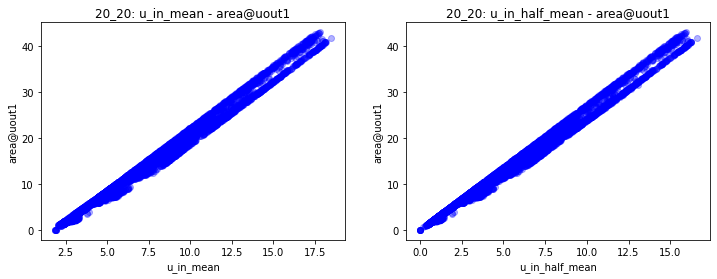

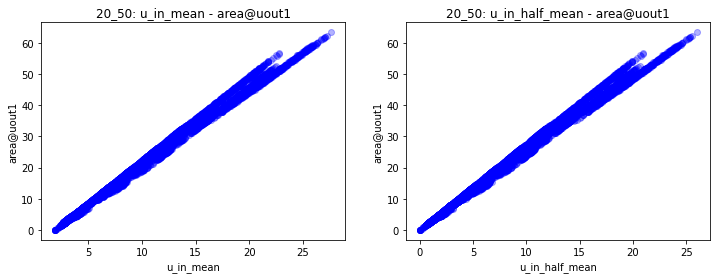

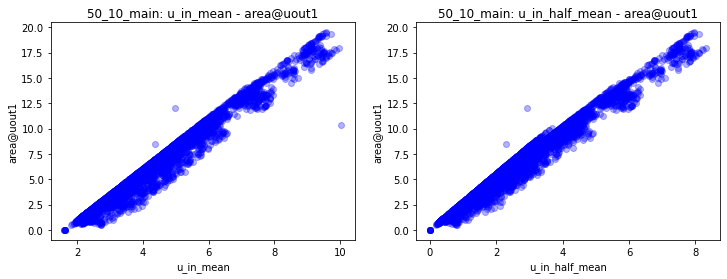

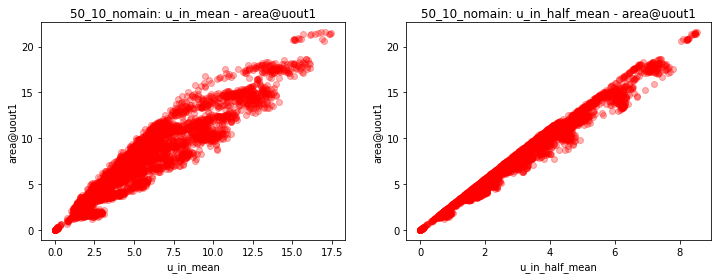

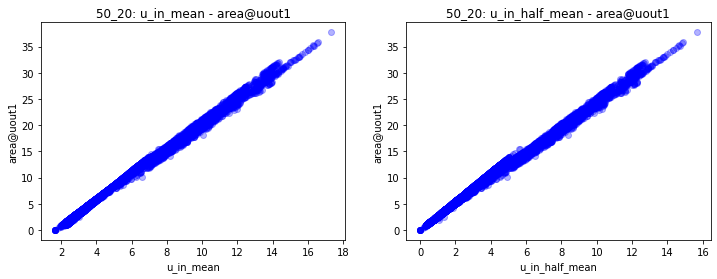

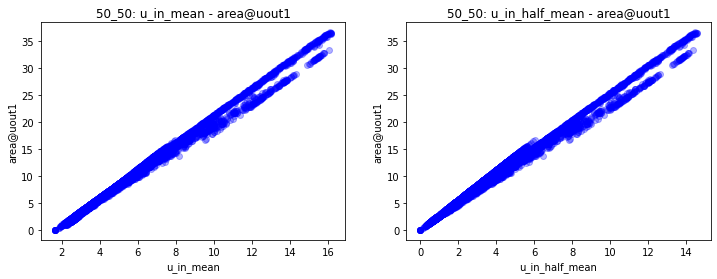

In [10]:
df = uout1_df
a = 0.3

for rc in RCmorder:
    t = df[df['R_Cm']==rc]
    #print(len(t))
    if len(t) == 0:
        continue
        
    if rc == '50_10_nomain':
        c = 'red'
    else:
        c = 'blue'
    
    fig = plt.figure(figsize = (12, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.scatter(t['u_in_mean'], t['area'], label=rc, alpha=a, color=c)
    ax1.set_xlabel('u_in_mean')
    ax1.set_ylabel('area@uout1')
    ax1.set_title(f'{rc}: u_in_mean - area@uout1')

    ax2.scatter(t['u_in_half_mean'], t['area'], label=rc, alpha=a, color=c)
    ax2.set_xlabel('u_in_half_mean')
    ax2.set_ylabel('area@uout1')
    ax2.set_title(f'{rc}: u_in_half_mean - area@uout1')

    #ax1.legend(loc=(1.1, 0.8))
    
    plt.show()

Mismatch only in "other than main mode". This is because the 'u_in' data after uout1 is different only in "other than main mode".

Here, 'u_in_half_mean' is mainly used to mean area @ u_out = 1.

And although there is a bias in the slope, there is a bias in the time distribution of time_uout1.

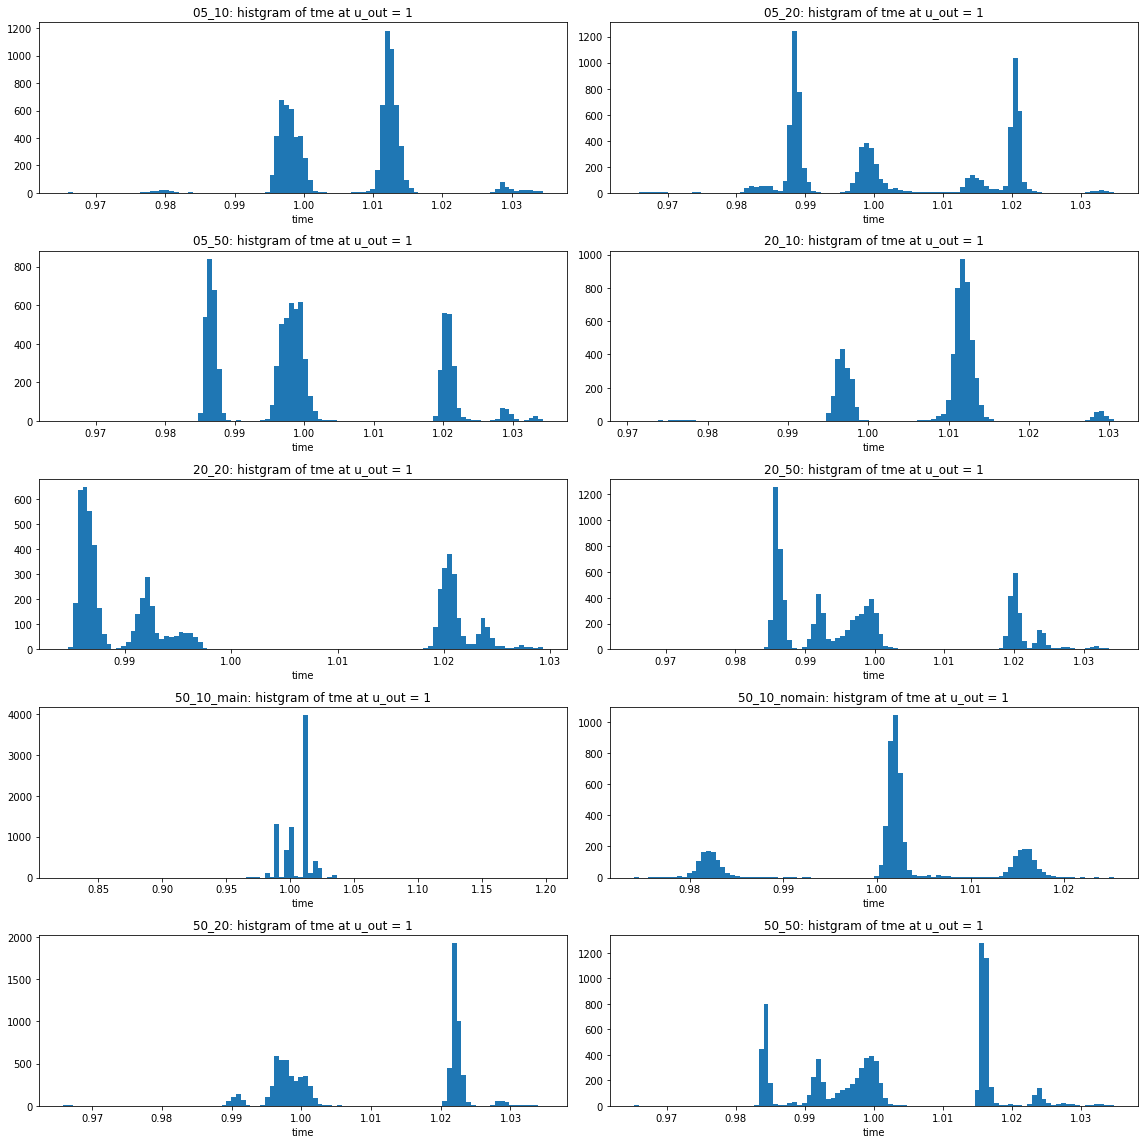

In [11]:
df = uout1_df
fig = plt.figure(figsize = (16, 16))

ax = [0] * 10

for i, rc in enumerate(RCmorder):
    ax[i] = fig.add_subplot(5, 2, i+1)
    t = df[df['R_Cm']==rc]
    if len(t) == 0:
        continue
    
    ax[i].hist(t['time_uout1'], bins=100)
    ax[i].set_title(f'{rc}: histgram of tme at u_out = 1')
    ax[i].set_xlabel('time')

fig.tight_layout()
plt.show()

Let's also look at the distribution of test

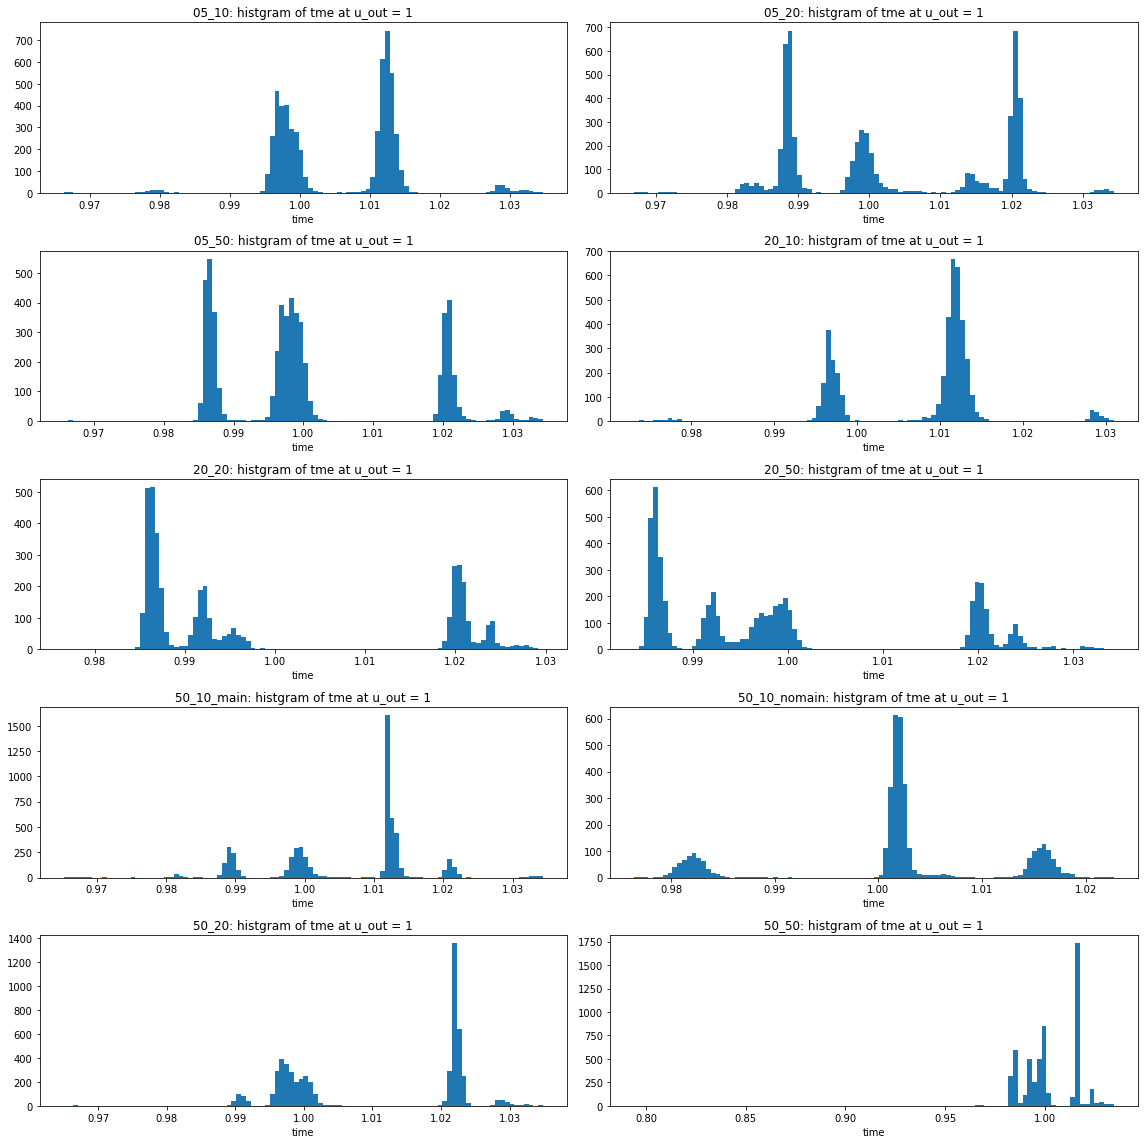

In [12]:
uout1_test = test[test['u_out_diff']==1]
df = uout1_test
fig = plt.figure(figsize = (16, 16))

ax = [0] * 10

for i, rc in enumerate(RCmorder):
    ax[i] = fig.add_subplot(5, 2, i+1)
    t = df[df['R_Cm']==rc]
    if len(t) == 0:
        continue
    
    ax[i].hist(t['time_uout1'], bins=100)
    ax[i].set_title(f'{rc}: histgram of tme at u_out = 1')
    ax[i].set_xlabel('time')

fig.tight_layout()
plt.show()

The graphs of 50_10_main and 50_50 look different depending on the large outliers, but they can all be regarded as the same distribution.

# Plot functions with colormap

In [13]:
def plot_time_uin_mean_cmap(RClist=RCmorder, xmin=0.8, xmax=1.2, ymin=0, ymax=35, vlmin=0, vlmax=0, alpha=0.5):
    df = uout1_df
    a = alpha

    for rc in RClist:
        t = df[df['R_Cm']==rc]
        n = len(t)
        if len(t) == 0:
            continue

        # color map
        cm = plt.cm.get_cmap('gist_ncar')

        fig = plt.figure(figsize = (16, 4))
        ax1 = fig.add_subplot(1, 1, 1)


        #x = t['time_step']
        x = t['time_uout1']
        y = t['u_in_half_mean']
        im1 = ax1.scatter(x, y, c=y, vmin=ymin, vmax=ymax, label=rc, alpha=a, cmap=cm)
        ax1.set_xlabel('time_uout1')
        ax1.set_ylabel('u_in_half_mean')
        ax1.set_title(f'{rc} ({n}): time_uout1 - u_in_half_mean')

        ax1.set_xlim(xmin, xmax)
        ax1.set_ylim(ymin, ymax)

        if vlmin or vlmax:
            ax1.vlines([vlmin, vlmax], ymin, ymax, "red", linestyles='dashed')
        
        fig.colorbar(im1, ax=ax1)

        plt.show()

def plot_double_pre_RCm_cmap(RCm, time_uout1_from=0.995, time_uout1_until=1.005, 
                             max_plots=False, ylim=100, alpha=False,
                            vmin=0, vmax=30):
    df=uout1_df
    t=df[df['R_Cm']==RCm]
    t=t[(t['time_uout1']>=time_uout1_from)&(t['time_uout1']<time_uout1_until)]

    bid_list = t['breath_id']
    
    print('The number of target charts:', len(bid_list))

    fig = plt.figure(figsize = (12, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    cm = plt.cm.get_cmap('gist_ncar')

    if alpha:
        a = alpha
    else:
        if (len(bid_list)):
            a = max(1.0/len(bid_list), 0.01)
        else:
            a = 1

    if not max_plots:
        max_plots = len(bid_list)

    ##############################
    ax1.set_xlabel('Time')
    ax1.set_ylabel('u_in')
    title_str = f'time - u_in'
    ax1.set_title(title_str)
    ax1.set_ylim(0,ylim)
    ##############################
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Pressure')
    title_str = f'time - pressure'
    ax2.set_title(title_str)
    ax2.set_ylim(0, ylim)
    ##############################

    print('The number of plotting:', len(bid_list[:max_plots]))
    for bid in tqdm(bid_list[:max_plots]):
        tmp = train.loc[train['breath_id'] == bid].reset_index(drop=True)

        line_df = train.loc[train['breath_id'] == bid].reset_index(drop=True)

        x  = line_df['time_step']
        y1 = line_df['u_in']
        y2 = line_df['pressure']
        c  = line_df['u_in_half_mean'].tolist()[0]

        #vmin=0
        #vmax=30
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=(vmin+vmax)/2)
        #print(cm(norm(c)))
        im1 = ax1.plot(x, y1, alpha=a, color=cm(norm(c)))
        im2 = ax2.plot(x, y2, alpha=a, color=cm(norm(c)))

    #fig.colorbar(mappable, ax=axa)

    fig.tight_layout()
    plt.show()



# Colored distribution of 'u_in_half_mean'for each R_C

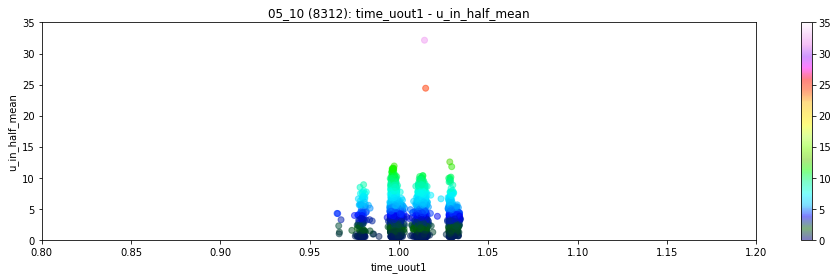

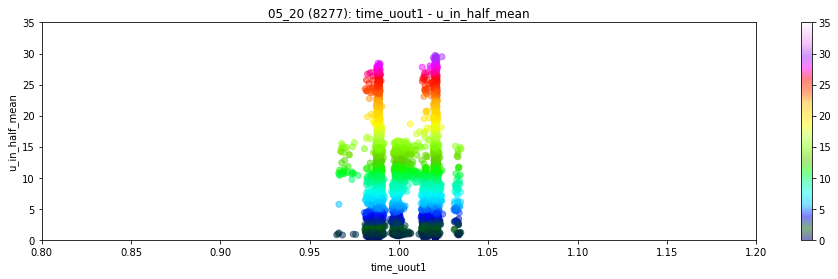

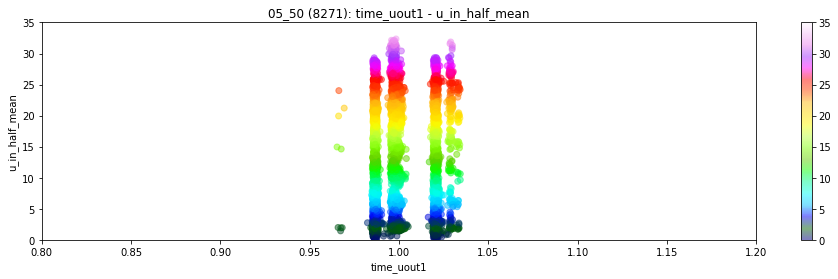

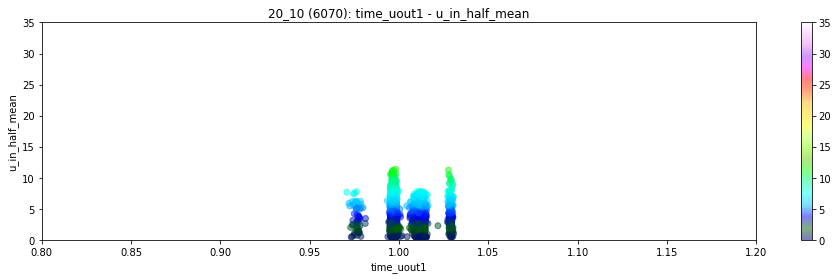

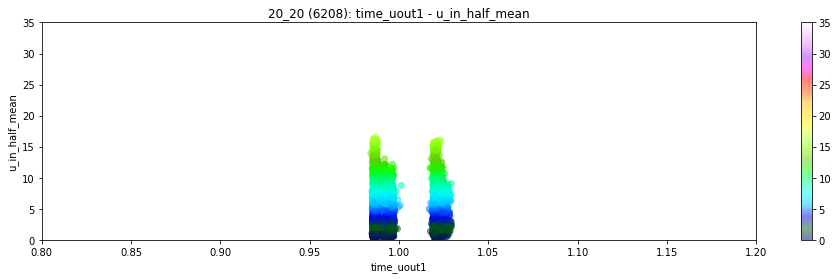

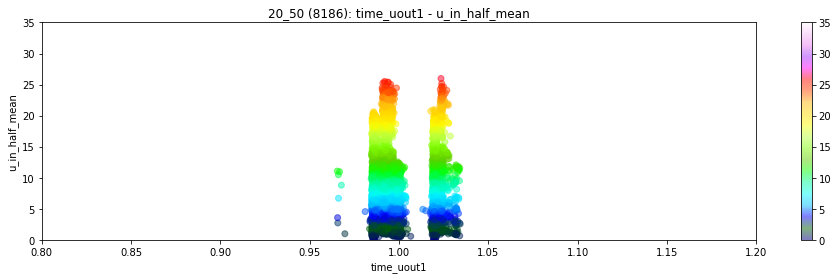

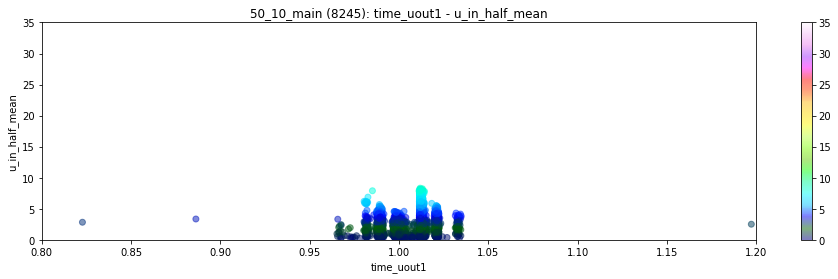

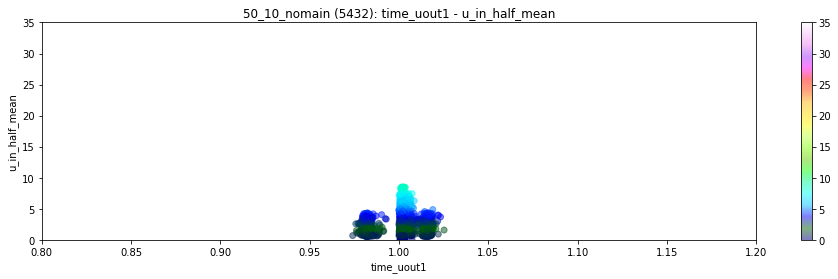

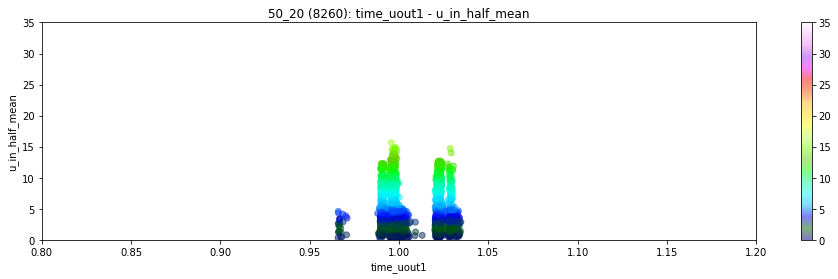

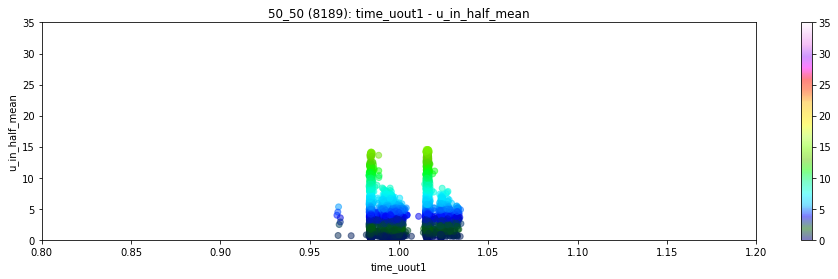

In [14]:
plot_time_uin_mean_cmap()

Let's zoom in and see.

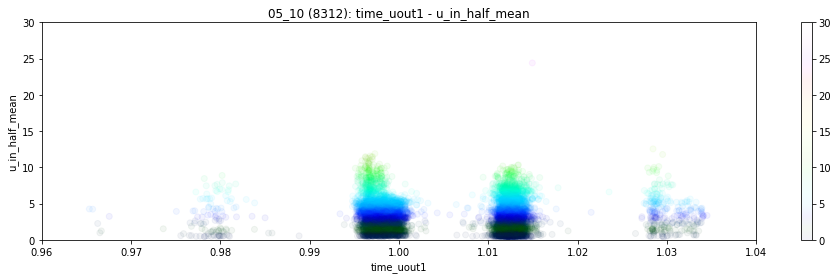

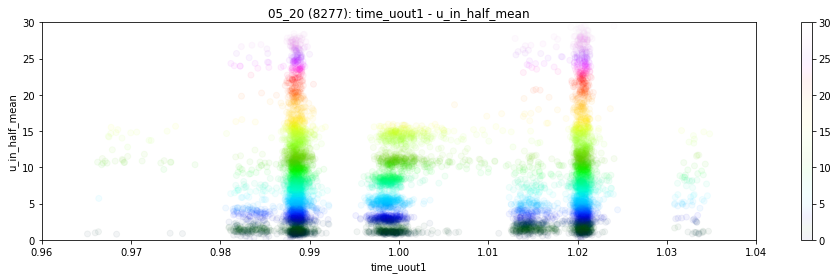

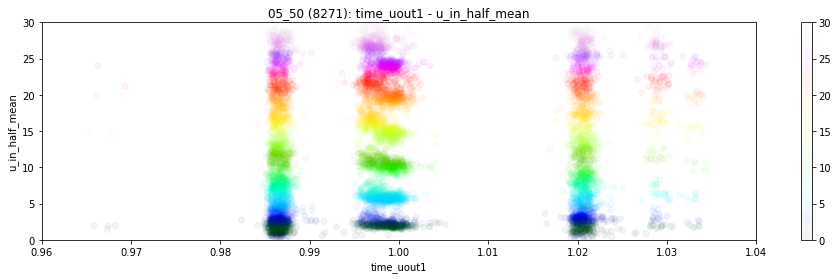

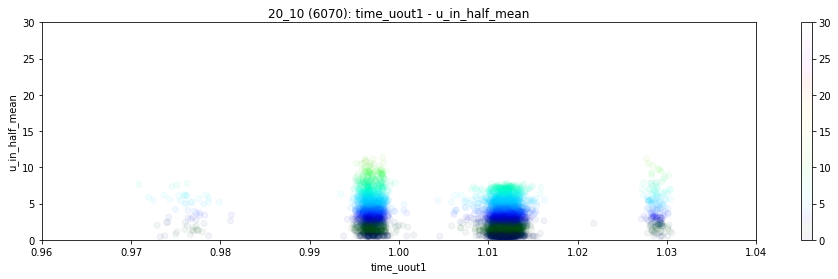

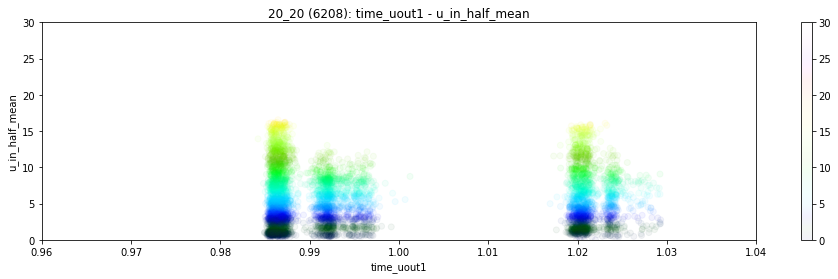

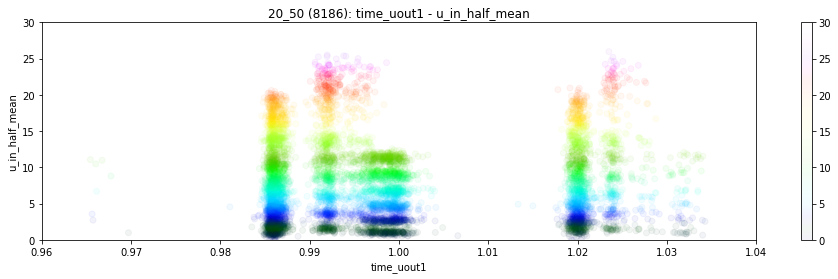

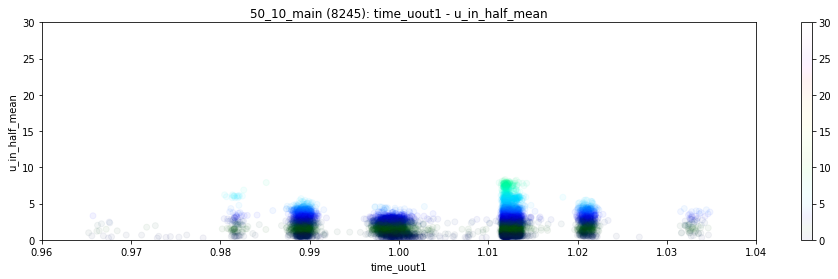

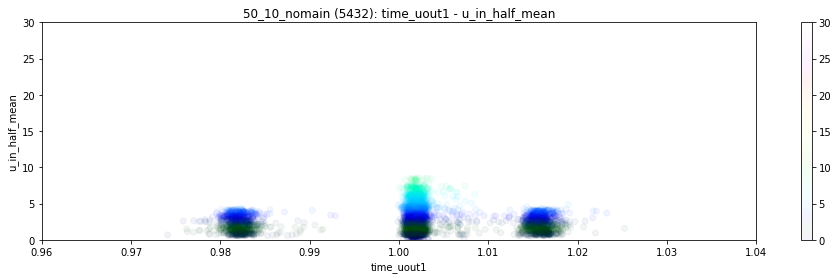

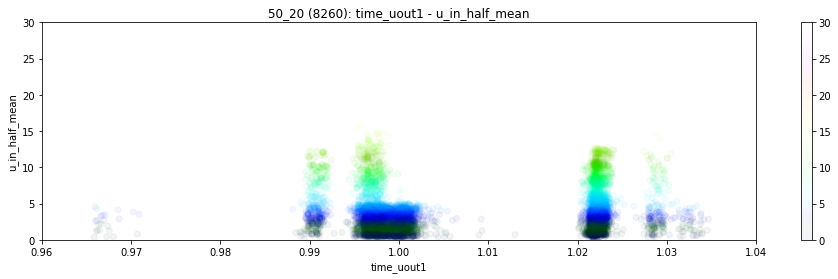

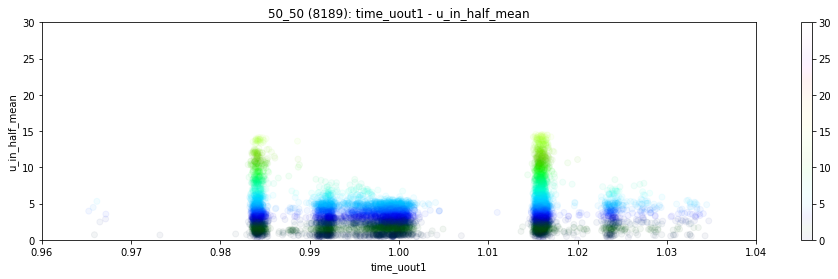

In [15]:
plot_time_uin_mean_cmap(ymax=30, xmin=0.96, xmax=1.04, alpha=0.05)

# Let's take a look at each chart!

# R_C: 05_20

In [16]:
def plot_colored_u_in_mean(RCm='05_20', time_from =0.995, time_until = 1.005, vmax = 30, alpha1=0.05, alpha2=False, ylim=100, max_plots=1000):
    plot_time_uin_mean_cmap(RClist=[RCm], ymax=vmax, xmin=0.96, xmax=1.04, alpha=alpha1, vlmin=time_from, vlmax=time_until)
    plot_double_pre_RCm_cmap(RCm, time_uout1_from=time_from, time_uout1_until=time_until, alpha=alpha2, 
                             max_plots=max_plots, vmin=0, vmax=vmax, ylim=ylim)

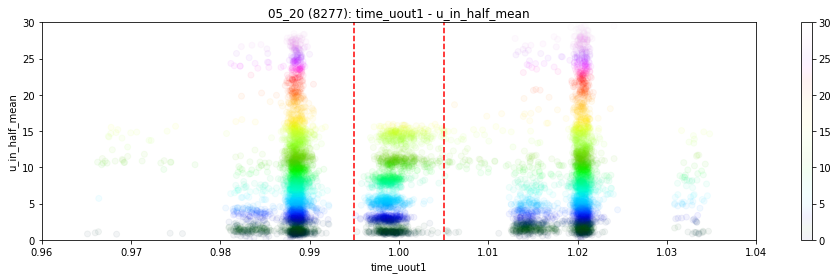

The number of target charts: 1834
The number of plotting: 1000


100%|██████████| 1000/1000 [00:13<00:00, 76.83it/s]


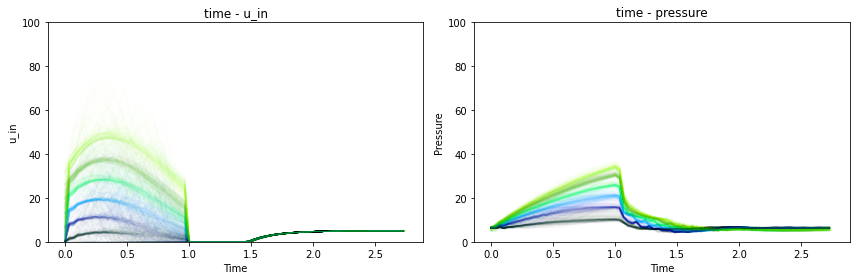

In [17]:
plot_colored_u_in_mean('05_20', time_from=0.995, time_until=1.005)

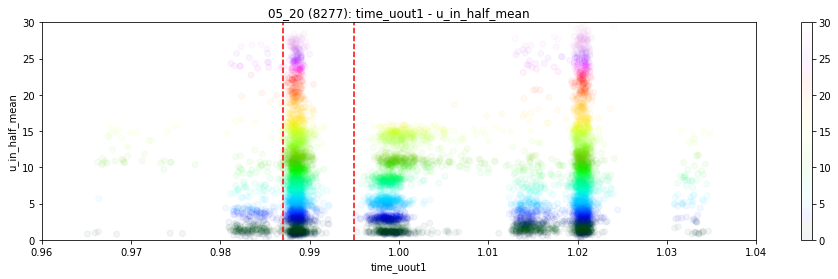

The number of target charts: 2910
The number of plotting: 1000


100%|██████████| 1000/1000 [00:12<00:00, 78.38it/s]


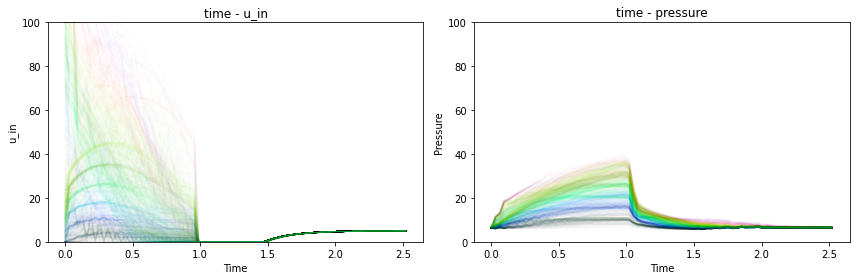

In [18]:
plot_colored_u_in_mean('05_20', time_from=0.987, time_until=0.995)

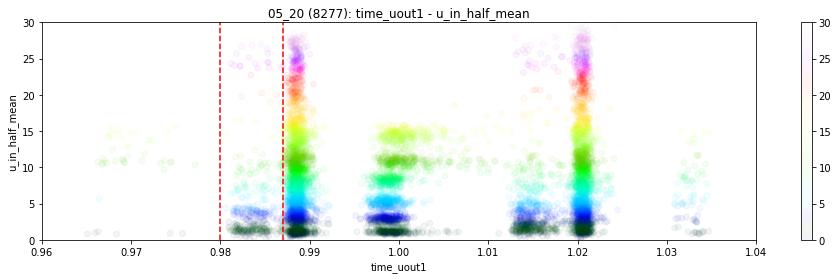

The number of target charts: 351
The number of plotting: 351


100%|██████████| 351/351 [00:04<00:00, 81.42it/s]


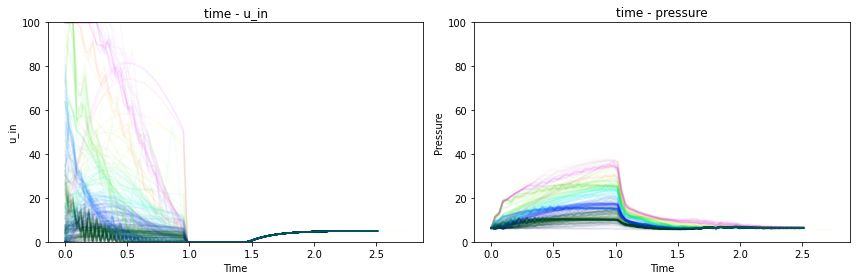

In [19]:
plot_colored_u_in_mean('05_20', time_from=0.980, time_until=0.987, alpha2=0.05)

# R_C: 05_50

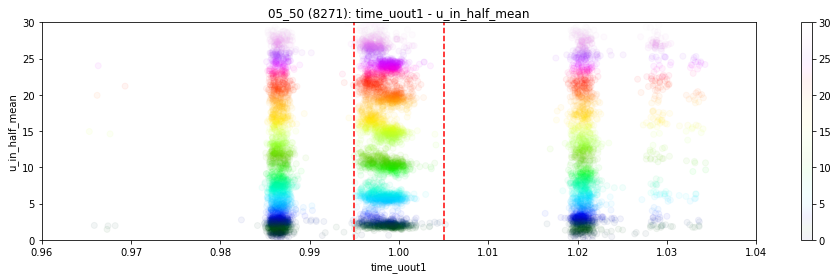

The number of target charts: 3751
The number of plotting: 1000


100%|██████████| 1000/1000 [00:13<00:00, 75.15it/s]


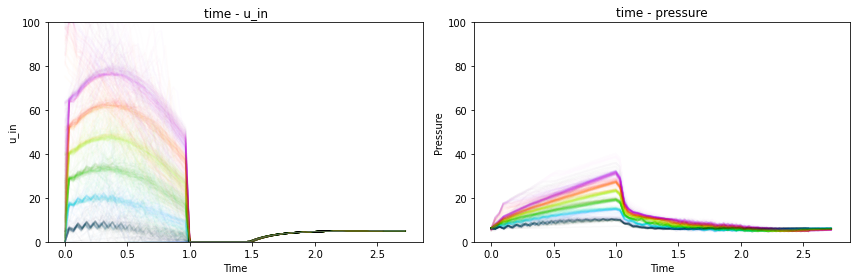

In [20]:
plot_colored_u_in_mean('05_50', time_from=0.995, time_until=1.005)

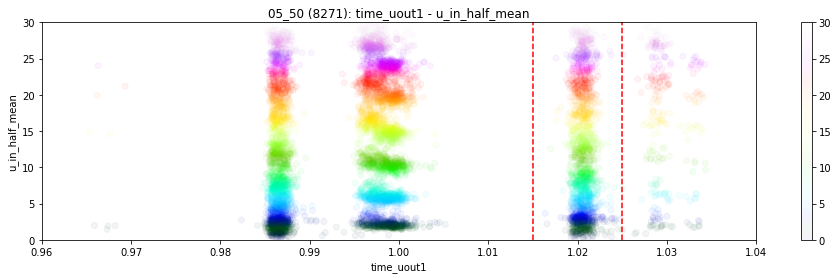

The number of target charts: 1808
The number of plotting: 1000


100%|██████████| 1000/1000 [00:12<00:00, 77.91it/s]


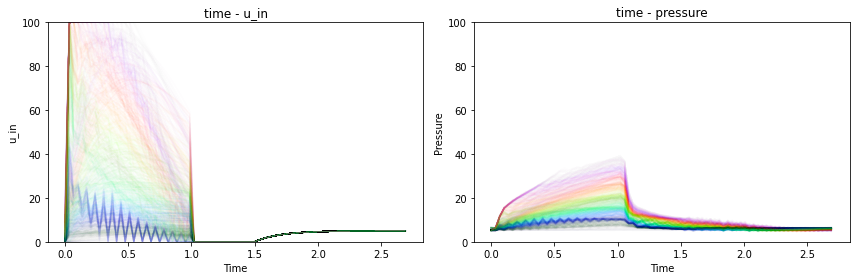

In [21]:
plot_colored_u_in_mean('05_50', time_from=1.015, time_until=1.025)

# R_C: 50_10_main

See [EDA about Pressure Part 1](https://www.kaggle.com/marutama/eda-about-pressure-part-1) for "main mode".

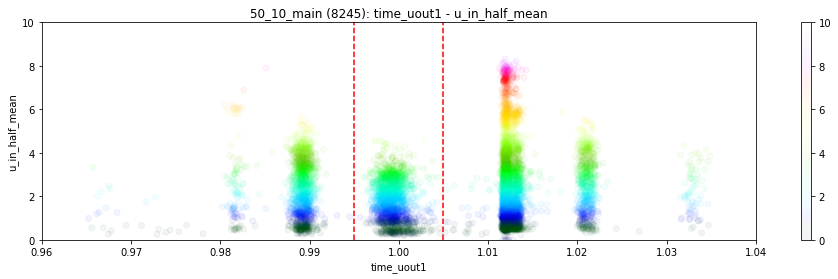

The number of target charts: 1954
The number of plotting: 1000


100%|██████████| 1000/1000 [00:13<00:00, 76.34it/s]


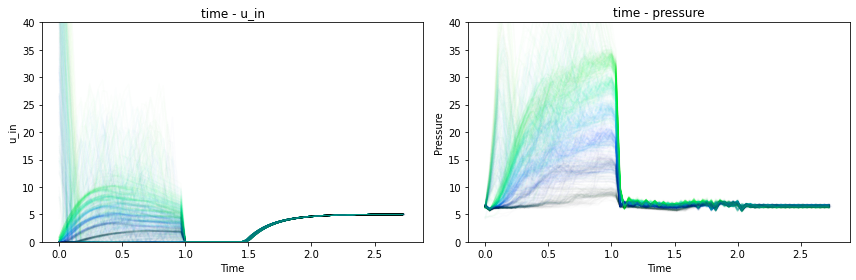

In [22]:
plot_colored_u_in_mean('50_10_main', time_from=0.995, time_until=1.005, vmax=10, ylim=40)

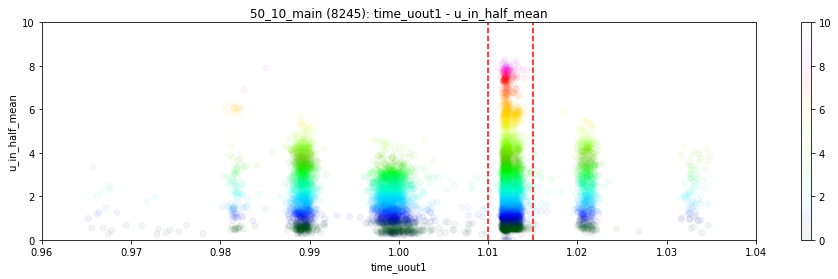

The number of target charts: 4066
The number of plotting: 1000


100%|██████████| 1000/1000 [00:13<00:00, 75.70it/s]


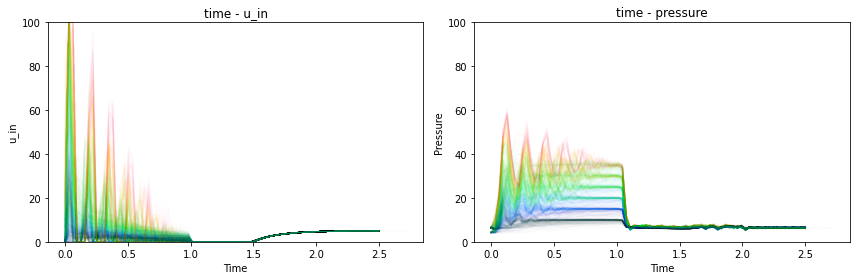

In [23]:
plot_colored_u_in_mean('50_10_main', time_from=1.010, time_until=1.015, vmax=10)

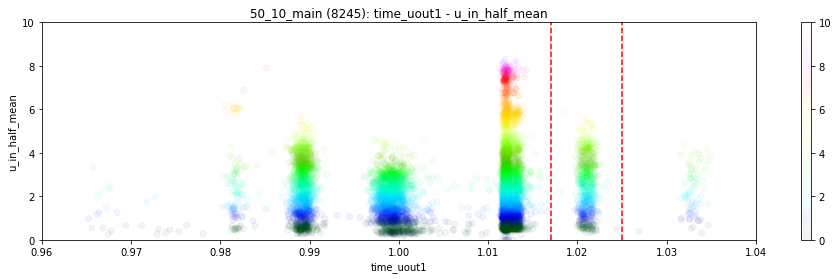

The number of target charts: 630
The number of plotting: 630


100%|██████████| 630/630 [00:08<00:00, 74.04it/s]


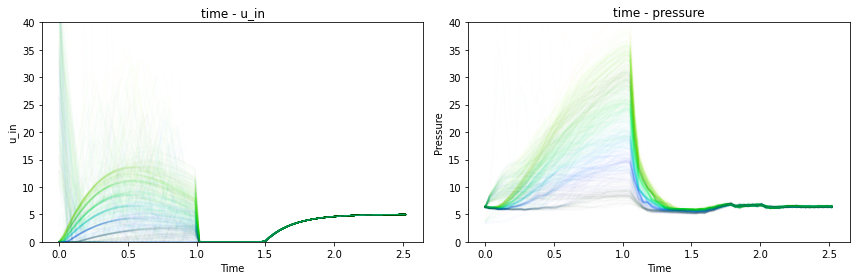

In [24]:
plot_colored_u_in_mean('50_10_main', time_from=1.017, time_until=1.025, vmax=10, ylim=40)

# R_C: 50_10_nomain

See [EDA about Pressure Part 2](https://www.kaggle.com/marutama/eda-about-pressure-part-2) for "other than main mode(nomain)".

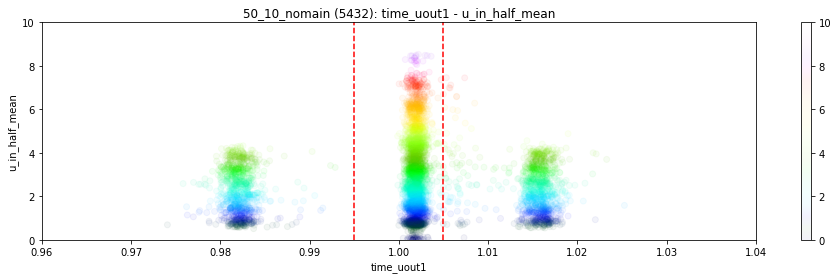

The number of target charts: 3327
The number of plotting: 1000


100%|██████████| 1000/1000 [00:12<00:00, 77.30it/s]


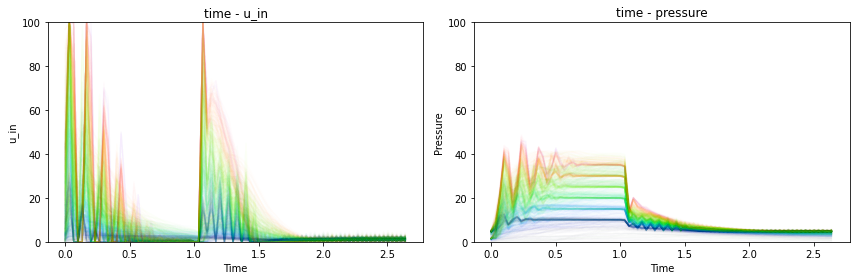

In [25]:
plot_colored_u_in_mean('50_10_nomain', time_from=0.995, time_until=1.005, vmax=10)

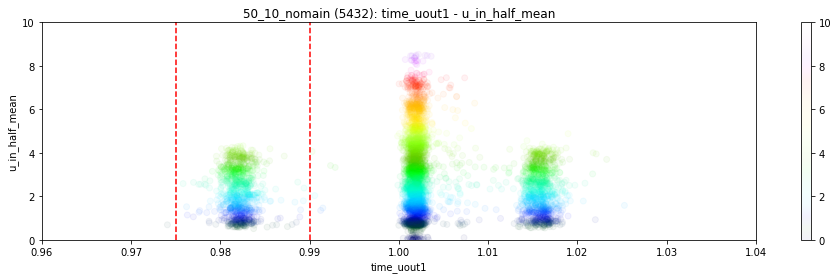

The number of target charts: 963
The number of plotting: 963


100%|██████████| 963/963 [00:13<00:00, 74.01it/s]


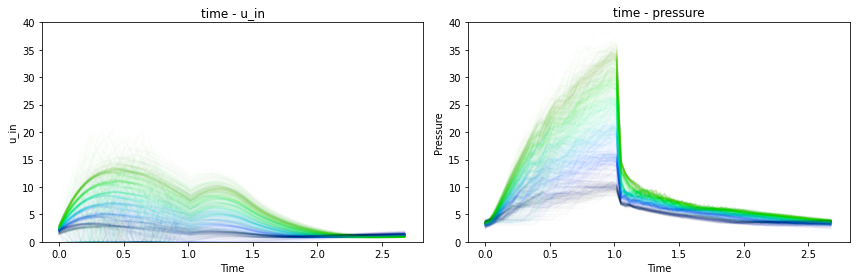

In [26]:
plot_colored_u_in_mean('50_10_nomain', time_from=0.975, time_until=0.990, vmax=10, ylim=40)

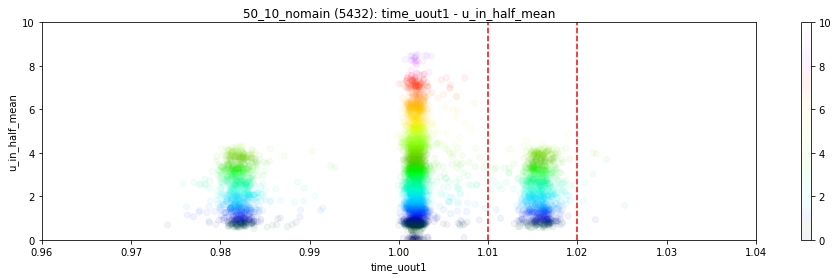

The number of target charts: 1048
The number of plotting: 1000


100%|██████████| 1000/1000 [00:12<00:00, 77.36it/s]


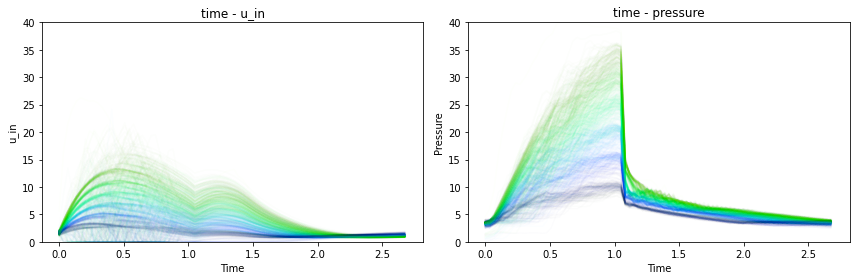

In [27]:
plot_colored_u_in_mean('50_10_nomain', time_from=1.010, time_until=1.020, vmax=10, ylim=40)

# R_C: 50_50

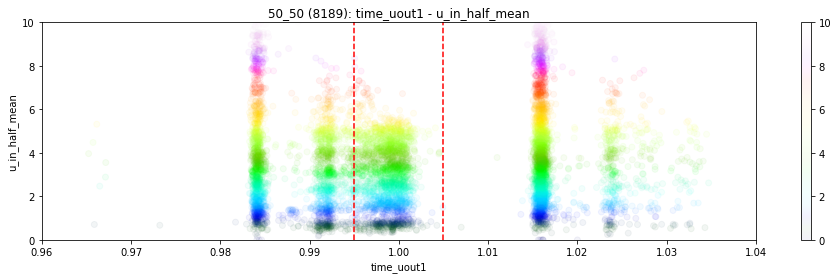

The number of target charts: 2357
The number of plotting: 1000


100%|██████████| 1000/1000 [00:13<00:00, 75.44it/s]


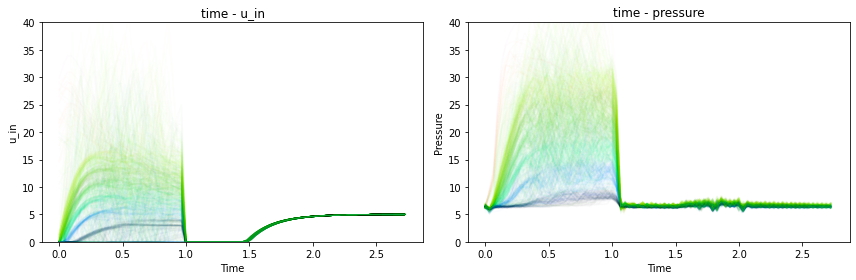

In [28]:
plot_colored_u_in_mean('50_50', time_from=0.995, time_until=1.005, vmax=10, ylim=40)

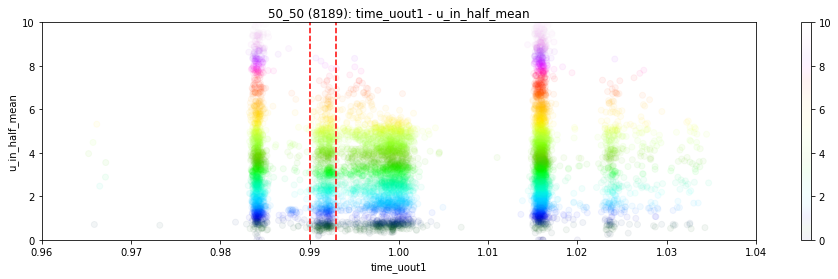

The number of target charts: 869
The number of plotting: 869


100%|██████████| 869/869 [00:11<00:00, 78.96it/s]


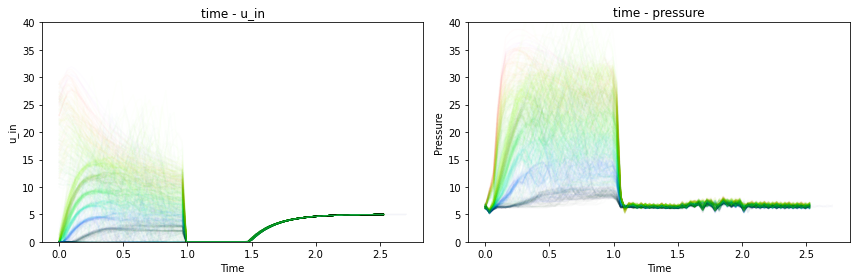

In [29]:
plot_colored_u_in_mean('50_50', time_from=0.990, time_until=0.993, vmax=10, ylim=40)

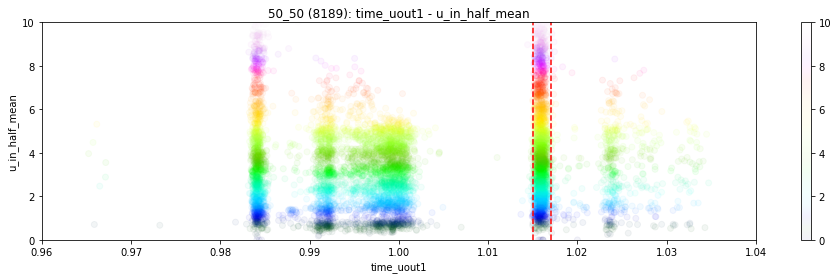

The number of target charts: 2655
The number of plotting: 1000


100%|██████████| 1000/1000 [00:13<00:00, 76.09it/s]


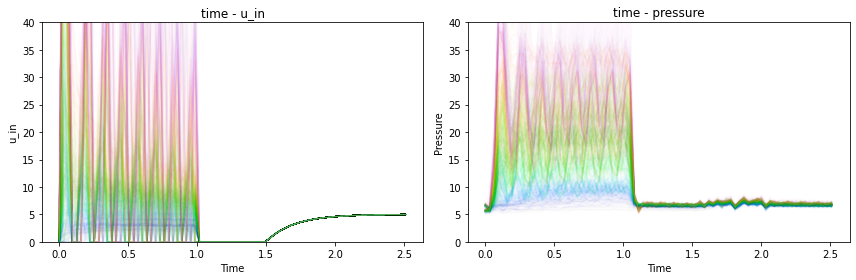

In [30]:
plot_colored_u_in_mean('50_50', time_from=1.015, time_until=1.017, vmax=10, ylim=40)

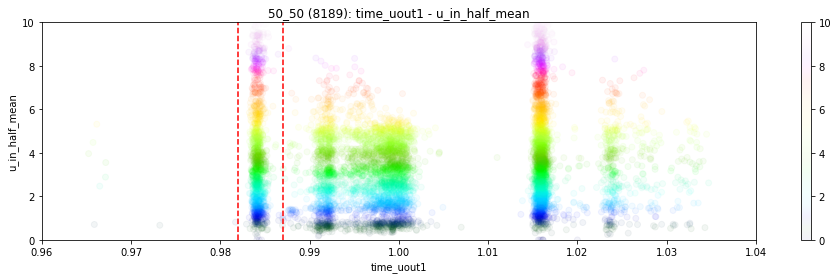

The number of target charts: 1448
The number of plotting: 1000


100%|██████████| 1000/1000 [00:12<00:00, 77.52it/s]


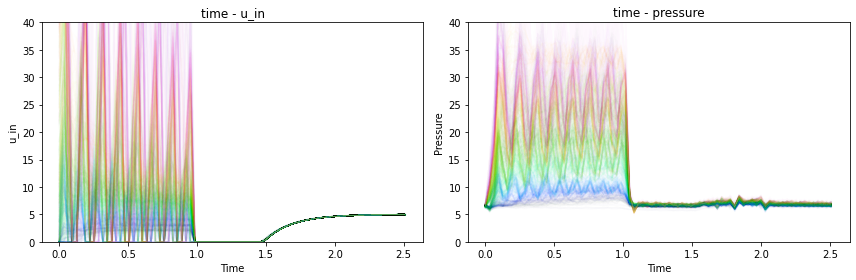

In [31]:
plot_colored_u_in_mean('50_50', time_from=0.982, time_until=0.987, vmax=10, ylim=40)

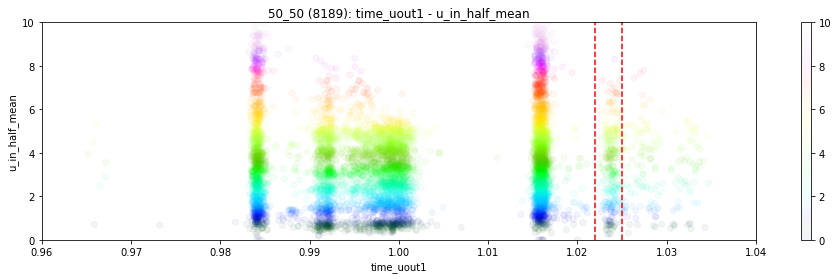

The number of target charts: 295
The number of plotting: 295


100%|██████████| 295/295 [00:04<00:00, 72.26it/s]


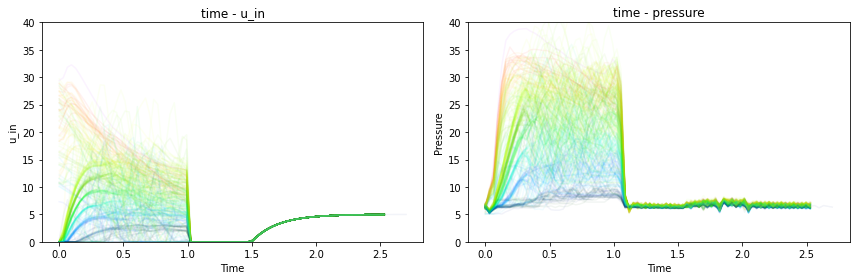

In [32]:
plot_colored_u_in_mean('50_50', time_from=1.022, time_until=1.025, vmax=10, ylim=40, alpha2=0.05)

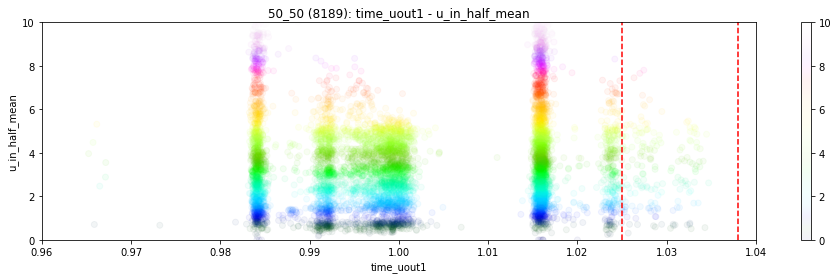

The number of target charts: 169
The number of plotting: 169


100%|██████████| 169/169 [00:02<00:00, 78.04it/s]


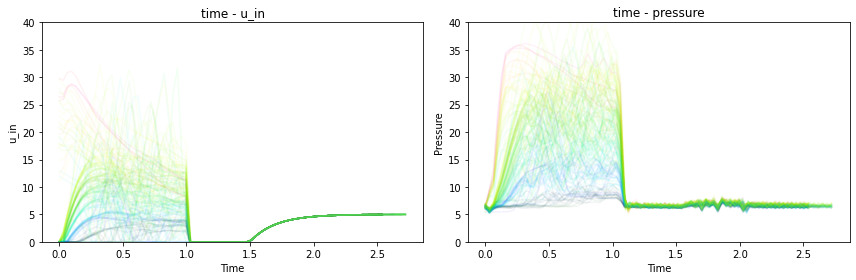

In [33]:
plot_colored_u_in_mean('50_50', time_from=1.025, time_until=1.038, vmax=10, ylim=40, alpha2=0.05)

# Please try various things and have fun!